# LocalZBackProjector

Calculate the height map from the projection and original images.

The data must be placed in two different folders:
    * `stack_dir`: for the original 3D images (1 chanel stack of the junction)
    * `proj_dir`: for the projection images (1 chanel image of the projection). The files must be named the same as in the `stack_dir` files, with in addition "-prediction.tif" at the end.
    
  

### Parameters

In [1]:
path = "data"    ## Path to the directory where the two folders are 
#path = "/run/user/1001/gvfs/smb-share:server=gaia.pasteur.fr,share=%40cdeh/CARE_LocalProj/data-Tom"
stack_dir = "Low-SNR-stack"       ## Folder containing the original 3D stacks
proj_dir = "ProjCARE-prediction"  ## Folder containing the projection results
res_dir = "BackProjection"        ## Name of the folder to create to put the results

imagename = "Notum-27.tif"   ## Image to analyse. Put None to analyze all the images in the `stack_dir` folder
#imagename = None             ## Image to analyse. Put None to analyze all the images in the `stack_dir` folder

step = 40        ## resolution of the zmap (square of step*step will be filled with the same Z)
winsize = 100    ## size of the window around the current step*step square to calculate the best Z
similarity_metric = "normalized_mutual_info"  ## Image to image comparison metric
smooth_map = 70  ## smoothing factor of the result zmap (0 to disable)
offset = 1       ## smallest Z in the Z-map: 0 for python, 1 for imagej/matlab compatibility 
save_reprojection = True  ## do and save the projection of the original stack with the calculted height map

### Imports and define functions to calculate the Z map (best similarity score)

In [2]:
import cv2 as cv
import numpy as np
import os
import tifffile
import skimage.metrics as imetrics
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool
from functools import partial

res_dir = os.path.join(path, res_dir)
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

In [3]:
def score_each_z( img3d, projimg, similarity ):
    """ Compare each z image to the projected image """
    best_score = [0,0]
    for z, zslice in enumerate(img3d):
        if similarity == "structural_similarity":
            score = imetrics.structural_similarity( zslice, projimg )
        if similarity == "normalized_mutual_info":
            score = imetrics.normalized_mutual_information(zslice, projimg) 
        if best_score[0] < score:
            best_score[0] = score
            best_score[1] = z
    return best_score[1]

def process_x(x, step, projimg, img, winsize, similarity_metric, offset): 
    """ For a given row, calculate and fill its best z """
    xstep = step
    if (x+xstep) > projimg.shape[0]:
        xstep = projimg.shape[0]-x
    zmap_x = np.zeros((xstep,projimg.shape[1]), "uint8")
    xmin = x-int(winsize/2)
    if xmin < 0:
        xmin = 0
    xmax = xmin+winsize
    if xmax > projimg.shape[0]:
        xmax = projimg.shape[0]
        xmin = projimg.shape[0]-winsize
    for y in range(0,projimg.shape[1],step):
        ymin = y-int(winsize/2)
        if ymin < 0:
            ymin = 0
        ymax = ymin+winsize
        if ymax > projimg.shape[0]:
            ymax = projimg.shape[0]
            ymin = projimg.shape[0]-winsize
   
        img3d = img[:,xmin:xmax,ymin:ymax]
        proj = projimg[xmin:xmax,ymin:ymax] 
        bestz = score_each_z( img3d, proj, similarity_metric )
        zmap_x[:,y:(y+step)] = bestz + offset
    return zmap_x

In [4]:
def backproj_oneimage( path, stackdir, proj_dir, res_dir, imagename, similarity_metric, step_size, window_size, offset):
    """ Local Z Back Projection of one image """
    imagefile = os.path.join(path, stack_dir, imagename+".tif")
    if not os.path.exists(imagefile):
        print("No original stack "+imagefile+" found")
        return
    
    img = tifffile.imread(imagefile)
    print("Processing image: "+str(imagename))
    print("Original stack size: "+str(img.shape))

    projname = os.path.join(path, proj_dir, imagename+"-prediction.tif")
    projimg = tifffile.imread(projname)

    start = time.time()
    zmap = np.zeros(projimg.shape, "uint8")
    pool = Pool(10)
    zmap_list = pool.map(partial(process_x, step=step_size, projimg=projimg, img=img, winsize=window_size, similarity_metric=similarity_metric, offset=offset), range(0,projimg.shape[0],step_size))
    for i, x in enumerate(range(0, projimg.shape[0], step_size)):
        zmap[x:(x+step_size),:] = zmap_list[i]                
    print("Took "+str( time.time()-start )+" s" )
    
    return zmap, img, projimg

def write_zmap( zmap, imagename, resdir ):
    """ Save the resulting ZMap to tiff file """
    outname = os.path.join(res_dir, imagename+"-zmap.tif")
    tifffile.imwrite(outname, zmap)
    
def write_reprojection( img, zmap, offset, imagename, resdir ):
    """ Save the projection of the original image with the calculated height map """
    if offset > 0:
        zmapoff = zmap - offset
    reproj = np.take_along_axis(img, zmapoff[np.newaxis], axis=0)[0]
    outname = os.path.join(res_dir, imagename+"-reprojed.tif")
    tifffile.imwrite(outname, reproj)
    return reproj

### Process all folder if no imagename parameter is None

In [5]:
if imagename is None:
    filelist = os.listdir(os.path.join(path, stack_dir))
    for cfile in filelist:
        if cfile.endswith(".tif"):
            imname = os.path.splitext(cfile)[0]
            zmap, img, projimg = backproj_oneimage(path, stack_dir, proj_dir, res_dir, imname, similarity_metric=similarity_metric, step_size=step, window_size=winsize, offset=offset)
            if smooth_map > 0:
                zmap = median_filter( zmap, size=smooth_map )
            write_zmap(zmap, imname, res_dir)
            if save_reprojection:
                write_reprojection(img=img, zmap=zmap, offset=offset, imagename=imname, resdir=res_dir)

### Process only one image if a filename was given

In [6]:
if imagename is not None:
    imname = os.path.splitext(imagename)[0]
    zmap, img, projimg = backproj_oneimage(path, stack_dir, proj_dir, res_dir, imname, similarity_metric=similarity_metric, step_size=step, window_size=winsize, offset=offset)

Processing image: Notum-27
Original stack size: (50, 2036, 2036)
Took 27.255879402160645 s


#### Smoothing the height map

Smoothing the resulting height map


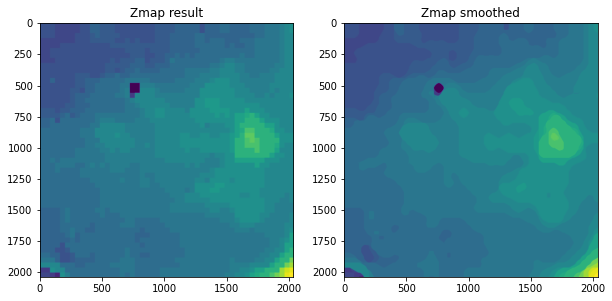

In [7]:
smoothing = smooth_map  ## change it here for testing

if imagename is not None:
    if smooth_map > 0:
        print("Smoothing the resulting height map")
        zmap_smooth = median_filter(zmap, size=smoothing)
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(10,8)
        plt.subplot(1,2,1)
        plt.imshow(zmap)
        plt.title("Zmap result")
        plt.subplot(1,2,2)
        plt.imshow(zmap_smooth)
        plt.title("Zmap smoothed")
    else:
        zmap_smooth = zmap
        
    ## save the smoothed map to file
    write_zmap(zmap_smooth, imname, res_dir)

#### Calculate the reprojection with the calculated (smoothed) zmap

Reprojecting the original stack


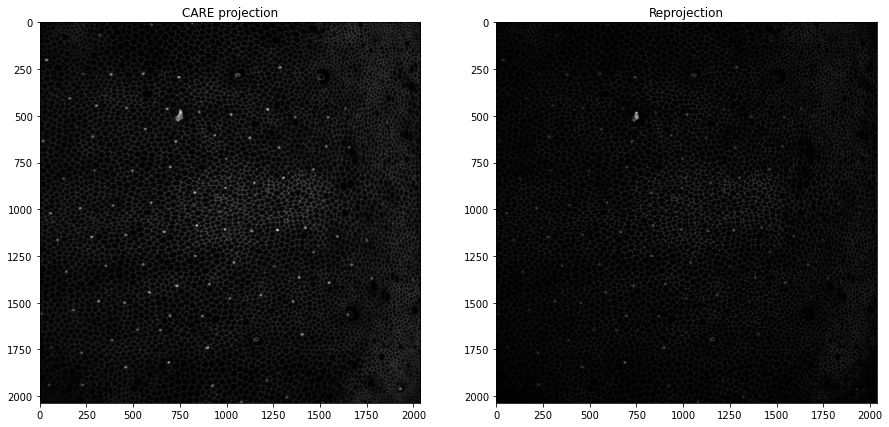

In [8]:
if (imagename is not None) and save_reprojection:
    print("Reprojecting the original stack")
    reproj = write_reprojection(img=img, zmap=zmap, offset=offset, imagename=imname, resdir=res_dir)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(15,10)
    plt.subplot(1,2,1)
    plt.imshow(projimg, cmap="gray")
    plt.title("CARE projection")
    plt.subplot(1,2,2)
    plt.imshow(reproj, cmap="gray")
    plt.title("Reprojection")